In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
BASE_DIR = './drive/My Drive/Kaggle/APTOS/data/'
TRAIN_IMAGE_DIR = './drive/My Drive/Kaggle/APTOS/data/train_images'
TEST_IMAGE_DIR = './drive/My Drive/Kaggle/APTOS/data/test_images'
train_csv = './drive/My Drive/Kaggle/APTOS/data/train.csv'
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train_df = pd.read_csv(train_csv)
train_df.head(10)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
5,0083ee8054ee,4
6,0097f532ac9f,0
7,00a8624548a9,2
8,00b74780d31d,2
9,00cb6555d108,1


In [0]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'

In [6]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
encoded_diagnosis = onehot_encoder.fit_transform(train_df[['diagnosis']])
print(encoded_diagnosis)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
print(encoded_diagnosis.shape)
print(encoded_diagnosis.astype)

(3662, 5)
<built-in method astype of numpy.ndarray object at 0x7f526704f350>


In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

Using TensorFlow backend.


In [10]:
train_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'training',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = True
)
test_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'validation',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GaussianNoise, GaussianDropout,GlobalAveragePooling2D
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import layers
from keras import regularizers, optimizers
from keras.callbacks import Callback, ModelCheckpoint


In [12]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2 
iresnet = InceptionResNetV2(include_top = False, weights='imagenet', input_shape=(224,224,3))
model = Sequential()
model.add(iresnet)
# model.add(Conv2D(filters = 1024, kernel_size = (2,2),padding = 'same'))
# model.add(BatchNormalization())
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=0.0001, amsgrad=True), metrics=['accuracy'])














219062272/219055592 [==============================] - 7s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
Total params: 54,344,421
Trainable params: 54,283,877
Non-trainable params: 60,544
_________________________________________________________________


In [14]:
checkpoint = ModelCheckpoint(
    'mobiletransfer.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(generator=train_gen,              
                                    steps_per_epoch=len(train_gen)//BATCH_SIZE,
                                    validation_data=test_gen,                    
                                    validation_steps=len(test_gen)//BATCH_SIZE,
                                    epochs=30,
                                    use_multiprocessing = True,
                                    verbose=1)



Epoch 1/30
11/11 [==============================] - 151s 14s/step - loss: 0.5907 - acc: 0.6909 - val_loss: 0.5151 - val_acc: 0.7875
Epoch 2/30
11/11 [==============================] - 133s 12s/step - loss: 0.4644 - acc: 0.8318 - val_loss: 0.3218 - val_acc: 0.8750
Epoch 3/30
11/11 [==============================] - 137s 12s/step - loss: 0.3667 - acc: 0.8580 - val_loss: 0.3007 - val_acc: 0.8938
Epoch 4/30
11/11 [==============================] - 131s 12s/step - loss: 0.2940 - acc: 0.8886 - val_loss: 0.2378 - val_acc: 0.9000
Epoch 5/30
11/11 [==============================] - 128s 12s/step - loss: 0.3045 - acc: 0.8818 - val_loss: 0.3481 - val_acc: 0.8375
Epoch 6/30
11/11 [==============================] - 129s 12s/step - loss: 0.2396 - acc: 0.8875 - val_loss: 0.2601 - val_acc: 0.8812
Epoch 7/30
11/11 [==============================] - 126s 11s/step - loss: 0.2531 - acc: 0.8977 - val_loss: 0.3264 - val_acc: 0.8625
Epoch 8/30
11/11 [==============================] - 127s 12s/step - loss: 

In [15]:
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

46/46 [==============================] - 122s 3s/step


In [0]:
# print(y_true.shape)
# print(y_true)
# print(y_test.shape)
# print(y_test)

In [0]:
# from sklearn.metrics import confusion_matrix 
# from sklearn.metrics import accuracy_score 
# from sklearn.metrics import classification_report 
# results = confusion_matrix(t_true, y_test) 
# print ('Confusion Matrix :')
# print(results) 
# print ('Accuracy Score :',accuracy_score(y_true, y_test)) 
# print ('Report : ')
# print (classification_report(, y_test)) 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


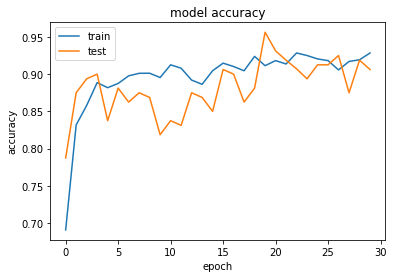

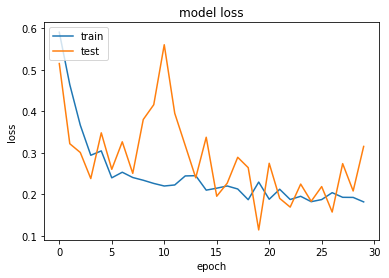

In [19]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()